# Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.spatial.distance import cdist

# Create maze

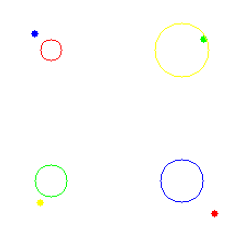

In [2]:
robots_position = [[40, 40], [160, 160], [40, 160], [160, 40]] # (x, y)
robots_radius = [10, 20, 15, 25]
robots_final_position = [[190, 190], [25, 25], [180, 30], [30, 180]] # (x, y)
robots_color = [(255, 0, 0), (0, 0, 255), (0, 255, 0), (255, 255, 0)]
assert len(robots_position) == len(robots_final_position) and len(robots_position) == len(robots_radius) and len(robots_position) == len(robots_color)
img_maze = 255 * np.ones(shape = (200, 200, 3)).astype(np.uint8)
for i in range(len(robots_position)):
    cv2.circle(img_maze, tuple(robots_final_position[i]), 3, robots_color[i], -1)
img_maze_copy = img_maze.copy()
for i in range(len(robots_position)):
    cv2.circle(img_maze_copy, tuple(robots_position[i]), robots_radius[i], robots_color[i], 1)
plt.imshow(img_maze_copy)
plt.axis('off')
plt.show()

# Global variables

In [3]:
t = 1
v_min, v_max = 5, 10
feasibility_radius = 50
robots_all_position = [[robots_position[i]] for i in range(len(robots_position))]
# speed_robots = [v_max] * len(robots_position) # to be changed
# directions_robots = [np.arctan2(robots_final_position[i][1] - robots_position[i][1], robots_final_position[i][0] - robots_position[i][0]) for i in range(len(robots_position))] # to be changed

# Iterations

In [4]:
completed_robots = []
while len(completed_robots) < len(robots_position):
    for i in range(len(robots_position)):
        if i in completed_robots: continue

        x, y = np.arange(0, img_maze.shape[1]), np.arange(0, img_maze.shape[0])
        mask = np.logical_and(((x[np.newaxis,:]-robots_position[i][0])**2 + (y[:,np.newaxis]-robots_position[i][1])**2 < v_max**2), ~((x[np.newaxis,:]-robots_position[i][0])**2 + (y[:,np.newaxis]-robots_position[i][1])**2 < v_min**2))
        # Uncomment to see how the mask looks like
        # plt.imshow(mask * 255, cmap = 'gray')
        # plt.show()
        reachable_avoidance_velocities = np.vstack(np.where(mask)[::-1]).T
        # print(reachable_avoidance_velocities.shape) # Uncomment to see the shape of reachable_avoidance_velocities

        for j in range(len(robots_position)):
            if i != j and np.linalg.norm(np.array(robots_position[i]) - np.array(robots_position[j])) < 500:
                x, y = np.arange(0, img_maze.shape[1]), np.arange(0, img_maze.shape[0])
                mask = (x[np.newaxis,:]-robots_position[j][0])**2 + (y[:,np.newaxis]-robots_position[j][1])**2 < (robots_radius[j] + robots_radius[i])**2
                reachable_avoidance_velocities = np.vstack(np.unravel_index(np.setdiff1d(np.ravel_multi_index(reachable_avoidance_velocities.T[::-1, :], img_maze.shape[:2]), np.ravel_multi_index(np.vstack(np.where(mask)), img_maze.shape[:2])), img_maze.shape[:2])).T[:, ::-1]
        robots_position[i] = reachable_avoidance_velocities[cdist(reachable_avoidance_velocities, np.array(robots_final_position[i]).reshape(1, -1)).argmin(axis = 0)].tolist()[0]

        if np.linalg.norm(np.array(robots_position[i]) - np.array(robots_final_position[i])) < 5: completed_robots.append(i)
    
    # Uncomment to see the output
    # img_maze_copy = img_maze.copy()
    # for j in range(len(robots_position)):
    #     cv2.circle(img_maze_copy, tuple(robots_position[j]), robots_radius[j], robots_color[j], 1)
    # plt.imshow(img_maze_copy)
    # plt.axis('off')
    # plt.show()

    for i in range(len(robots_position)):
        robots_all_position[i].append(robots_position[i])

# Results

In [5]:
time_steps = 7

In [6]:
video = cv2.VideoWriter('four_obstacles.mp4', cv2.VideoWriter_fourcc(*'DIVX'), 30, img_maze.shape[:2])
for i in range(len(robots_all_position[0]) - 1):
    list_frames = [img_maze.copy() for j in range(time_steps)]
    for rob_no in range(len(robots_all_position)):
        current_point_x, current_point_y, next_point_x, next_point_y = *robots_all_position[rob_no][i], *robots_all_position[rob_no][i+1]
        indices = np.vstack([np.linspace(start = current_point_x, stop = next_point_x, num = time_steps, endpoint = False).round().astype(np.int), np.linspace(start = current_point_y, stop = next_point_y, num = time_steps, endpoint = False).round().astype(np.int)]).T
        for j in range(time_steps):
            cv2.circle(list_frames[j], tuple(indices[j]), robots_radius[rob_no], robots_color[rob_no], 1)
    for j in range(time_steps):
        # plt.imshow(list_frames[j])
        # plt.axis('off')
        # plt.show()
        video.write(list_frames[j])
video.release()